In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier

## Обзор данных

In [2]:
data = pd.read_csv('users_behavior.csv')

data.info()

data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


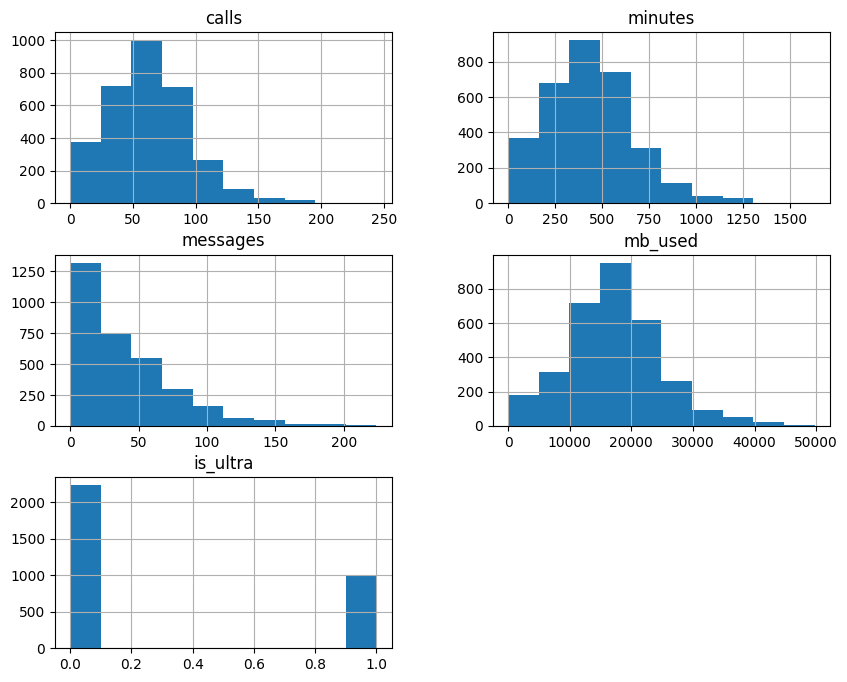

In [3]:
data.hist(figsize=(10, 8));

В задании заявлено, что предобработка данных не требуется, единственное, что можно заменить типы данных в столбцах `calls` и `messages` на `int`, проверить данные на явные дубликаты и сразу перейти к следующей части.

In [4]:
data[['calls', 'messages']] = data[['calls', 'messages']].astype('int')

In [5]:
data.duplicated().sum()

0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


Посмотрим на коореляции в данных

In [7]:
data[['calls', 'minutes', 'messages', 'mb_used']].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


Посмотрим на мультиколлинеарность

In [8]:
X_variables = data[['calls', 'minutes', 'messages', 'mb_used']]

vif_data = pd.DataFrame()
vif_data['feature'] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,calls,129.350246
1,minutes,126.448586
2,messages,2.184385
3,mb_used,4.380105


Мультиколлинеарность присутствует, но в рамках задачи с ней бороться не обязательно.

## Разделение данных на выборки

Данные нужно разбить на три части: обучающую, валидационную и тестовую. Используем стандартное соотношение 3:1:1.

In [9]:
data_train, data_valid_and_test = train_test_split(data, test_size=0.4, random_state=345, stratify=data['is_ultra'])
data_valid, data_test = train_test_split(data_valid_and_test, test_size=0.5, random_state=345, stratify=data_valid_and_test['is_ultra'])

In [10]:
data_train.shape

(1928, 5)

In [11]:
data_valid.shape

(643, 5)

In [12]:
data_test.shape

(643, 5)

## Исследование моделей

Данные разбили, теперь исследуем разные модели. Перед нами стоит задача классификации. В обучающем курсе было 3 модели: решающее дерево, случайный лес и логическая регрессия.

Вначале разобьем выборки на целевые признаки и обучающие.

In [13]:
train_features = data_train.drop(['is_ultra'], axis=1)
train_target = data_train['is_ultra']

valid_features = data_valid.drop(['is_ultra'], axis=1)
valid_target = data_valid['is_ultra']

test_features = data_test.drop(['is_ultra'], axis=1)
test_target = data_test['is_ultra']

### Решающее дерево

Изучим модель решающего дерева с вариацией критериев и глубины дерева.

,criterion,max_depth,accuracy
57,entropy,8,0.805599
59,entropy,10,0.802488
7,gini,8,0.793157
9,gini,10,0.788491
56,entropy,7,0.786936
...,...,...,...
73,entropy,24,0.729393
70,entropy,21,0.727838
72,entropy,23,0.723173
19,gini,20,0.723173


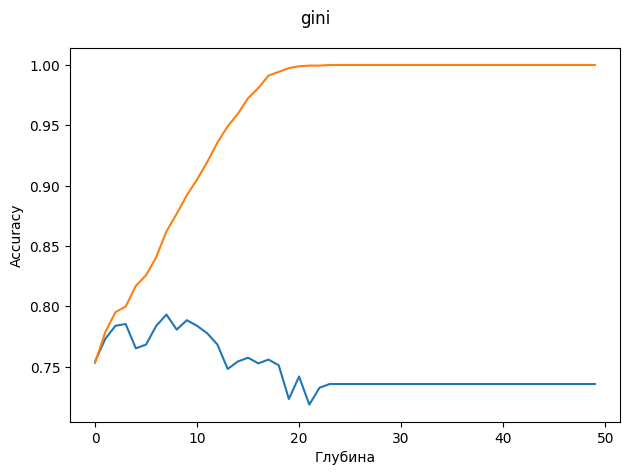

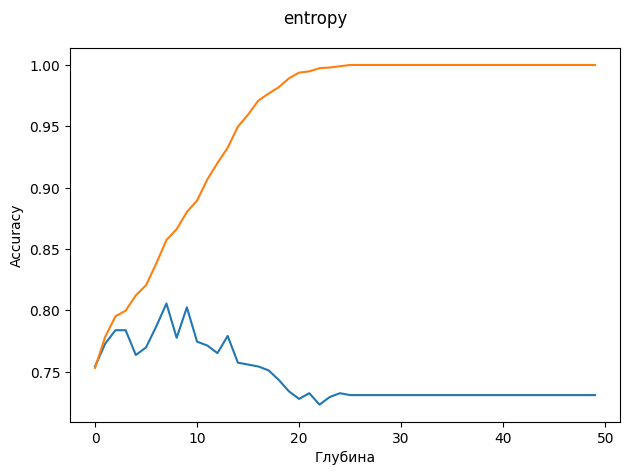

In [14]:
test_of_tree = pd.DataFrame(columns=['criterion', 'max_depth', 'accuracy'])

criterions = ('gini', 'entropy')

for criterion in criterions:
    accuracy_valid = []
    accuracy_train = []
    for depth in range(1, 51):
        tree_model = DecisionTreeClassifier(
            criterion=criterion,
            max_depth=depth,
            random_state=345
        )
        tree_model.fit(train_features, train_target)
        predictions_valid = tree_model.predict(valid_features)
        predictions_train = tree_model.predict(train_features)
        test_of_tree = test_of_tree.append(
            pd.DataFrame(
                [[criterion, depth, accuracy_score(valid_target, predictions_valid)]], 
                columns=['criterion', 'max_depth', 'accuracy']),
            ignore_index=True)
        accuracy_valid.append(accuracy_score(valid_target, predictions_valid))
        accuracy_train.append(accuracy_score(train_target, predictions_train))
    
    fig, ax = plt.subplots()
    fig.suptitle(criterion)
    
    ax.plot(accuracy_valid, label='Валидационная выборка')
    ax.plot(accuracy_train, label='Тренировочная выборка')
    ax.set(xlabel='Глубина', ylabel='Accuracy')
    
    fig.tight_layout()

test_of_tree.sort_values(by='accuracy', ascending=False)

**Вывод:** оптимально использовать модель с критерием `entropy` и `max_depth=8`, при этом значение `accuracy` = 0.805599

### Случайный лес

Изучим модель случайного леса с вариацией глубины дерева и числом деревьев.

In [15]:
test_of_forest = pd.DataFrame(columns=['n_estimators', 'max_depth', 'accuracy'])
for est in tqdm(range(1, 51)):
    for depth in range(1, 11):
        forest_model = RandomForestClassifier(
            n_estimators=est, 
            max_depth=depth, 
            random_state=345
        )
        forest_model.fit(train_features, train_target)
        predictions_valid = forest_model.predict(valid_features)
        test_of_forest = test_of_forest.append(pd.DataFrame([[est, depth, accuracy_score(valid_target, predictions_valid)]], columns=['n_estimators', 'max_depth', 'accuracy']), ignore_index=True)

test_of_forest.sort_values(by='accuracy', ascending=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.19it/s]


,n_estimators,max_depth,accuracy
407,41,8,0.828927
477,48,8,0.828927
397,40,8,0.828927
497,50,8,0.828927
347,35,8,0.827372
...,...,...,...
60,7,1,0.726283
19,2,10,0.726283
100,11,1,0.723173
90,10,1,0.723173


**Вывод:** очевидно, лучшая модель имеет `n_estimators=40` и `max_depth=8`, при этом значение `accuracy` = 0.828927

### Логичестикая регрессия

In [16]:
logistic_model = LogisticRegression(random_state=345)
logistic_model.fit(train_features, train_target)
predictions_valid = logistic_model.predict(valid_features)
print('Accuracy:', accuracy_score(valid_target, predictions_valid))

Accuracy: 0.7060653188180405


## Вывод

Лучшую точность `0.828927` мы получили на модели случайного леса, при этом, точность модели решающего дерева `0.805599`, а логистической регрессии `0.706065`.

## Проверка модели на тестовой выборке

Возьмем лучшую модель: случайный лес с с `n_estimators=40` и `max_depth=8`

In [17]:
forest_model = RandomForestClassifier(n_estimators=40, max_depth=8, random_state=345)
forest_model.fit(train_features, train_target)
predictions_test = forest_model.predict(test_features)

print('Accuracy:', accuracy_score(test_target, predictions_test))

Accuracy: 0.8164852255054432


**Вывод:** По RF модели на тестовой выборке получена точность более 81,6%.

## Проверка модели на адекватность

In [18]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=345)
dummy_model.fit(train_features, train_target)
result_dummy = dummy_model.score(valid_features, valid_target)
print('Accuracy DummyClassifier:', result_dummy)

Accuracy DummyClassifier: 0.6936236391912908


**Вывод:** так как accuracy DC меньше, чем accuracy выбранной модели, то нашу модель можно считать адекватной.

## Общий вывод

* Были исследованы модели `DecisionTree`, `RandomForest` и `LogisticRegression`
* Наибольшую точность показали модели `DecisionTree` с критерием `gini` и гиперпараметром `max_depth=7` - `0.786936` и `RandomForest` с гиперпараметрами `n_estimators=9` и `max_depth=10` - `0.800933`
* Выбранная нами модель RF показывает точность на тестовых данных более 81,6%.
* Нашу модель можно назвать адекватной.